In [1]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import clear_output
import wandb
from wandb.keras import WandbCallback

import helpers
from model import Unet
import temp

# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
# tf.config.run_functions_eagerly(True)

## Prepare dataset

In [2]:
DATA_PATH   = "C:/Users/roboj/Desktop/DP/data/pancreas/"
IMAGE_SIZE  = (128, 128)
BUFFER_SIZE = 1000

image_paths, mask_paths = helpers.load_image_and_mask_paths(DATA_PATH)
image_paths, mask_paths = image_paths[-40:], mask_paths[-40:] # TODO
dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
dataset = dataset.map(helpers.load_images_and_masks(IMAGE_SIZE))
train_ds, val_ds = helpers.split(dataset, 0.8)

TRAIN_LENGTH    = train_ds.cardinality().numpy()
VAL_LENGTH      = val_ds.cardinality().numpy()
# TEST_LENGTH     = test_ds.cardinality().numpy()
BATCH_SIZE      = 2
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
NUM_EPOCHS      = 30
VAL_STEPS       = VAL_LENGTH // BATCH_SIZE
# VAL_SUBSPLITS   = 5 # TODO
# VAL_STEPS       = VAL_LENGTH // BATCH_SIZE // VAL_SUBSPLITS # TODO

wandb.config = {
  "epochs": NUM_EPOCHS,
  "batch_size": BATCH_SIZE
}
wandb.init(project="Nerve segmentation ", entity="xjackor")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


In [3]:
print(f"TRAIN: {TRAIN_LENGTH}\nVAL: {VAL_LENGTH}")
# print(f"TRAIN: {TRAIN_LENGTH}\nVAL: {VAL_LENGTH}\nTEST: {TEST_LENGTH}")

TRAIN: 32
VAL: 8


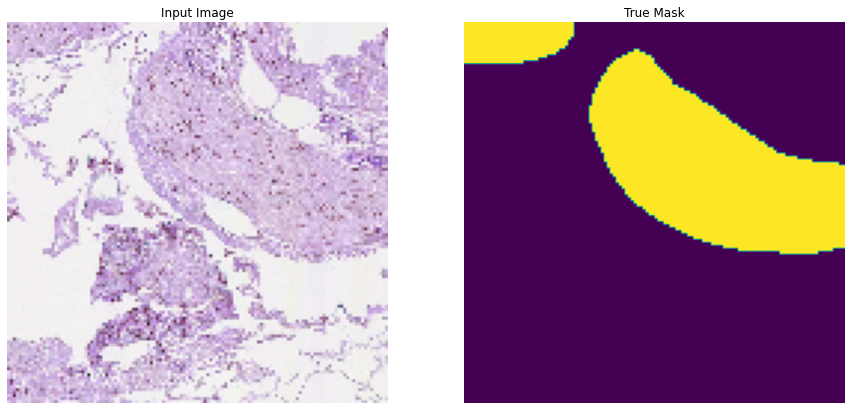

In [4]:
image, mask = next(iter(dataset))
helpers.show(image, mask)

In [5]:
# TODO: Upgrade this: https://www.tensorflow.org/guide/data
train_batches = (train_ds.shuffle(BUFFER_SIZE)
                         .batch(BATCH_SIZE)
                         .repeat()
                         .prefetch(buffer_size=tf.data.AUTOTUNE))
val_batches = val_ds.batch(BATCH_SIZE)

In [6]:
unet_model = Unet((*IMAGE_SIZE, 3))
unet_model.tf_model.compile(optimizer=tf.keras.optimizers.Adam(),
                            loss="bce",
                            metrics=tf.keras.metrics.MeanIoU(num_classes=2))
unet_model.tf_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 32  9248        ['conv2d[0][0]']                 
                                )                                                             

1/1 [==============================] - 11s 11s/step


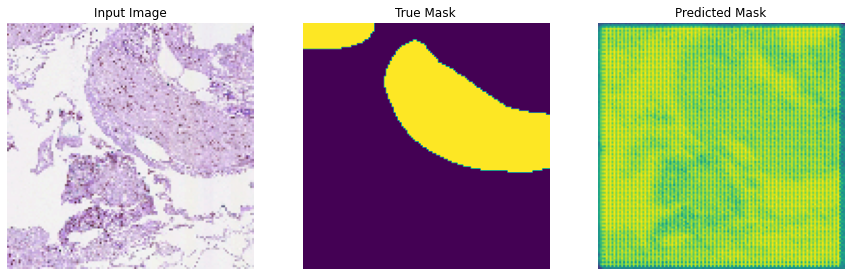

In [7]:
helpers.show(image, mask, unet_model.predict(image))

In [8]:
# TODO
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        helpers.show(image, mask, unet_model.predict(image))
        print("\nSample Prediction after epoch {}\n".format(epoch + 1))

In [9]:
model_history = unet_model.tf_model.fit(train_batches,
                                        epochs=NUM_EPOCHS,
                                        steps_per_epoch=STEPS_PER_EPOCH,
                                        validation_steps=VAL_STEPS,
                                        validation_data=val_batches,
                                        callbacks=[WandbCallback()])

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/30
16/16 [==============================] - ETA: 0s - loss: 0.4727 - mean_io_u: 0.4444

INFO:tensorflow:Assets written to: c:\Users\roboj\Desktop\DP\src\nerve_segmentation\wandb\run-20221125_232754-3ip874ta\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\roboj\Desktop\DP\src\nerve_segmentation\wandb\run-20221125_232754-3ip874ta\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\roboj\Desktop\DP\src\nerve_segmentation\wandb\run-20221125_232754-3ip874ta\files\model-best)... Done. 4.2s


16/16 [==============================] - 83s 5s/step - loss: 0.4727 - mean_io_u: 0.4444 - val_loss: 0.3605 - val_mean_io_u: 0.4448
Epoch 2/30
16/16 [==============================] - ETA: 0s - loss: 0.3549 - mean_io_u: 0.4424

INFO:tensorflow:Assets written to: c:\Users\roboj\Desktop\DP\src\nerve_segmentation\wandb\run-20221125_232754-3ip874ta\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\roboj\Desktop\DP\src\nerve_segmentation\wandb\run-20221125_232754-3ip874ta\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\roboj\Desktop\DP\src\nerve_segmentation\wandb\run-20221125_232754-3ip874ta\files\model-best)... Done. 4.2s


16/16 [==============================] - 41s 3s/step - loss: 0.3549 - mean_io_u: 0.4424 - val_loss: 0.2905 - val_mean_io_u: 0.4561
Epoch 3/30
16/16 [==============================] - 8s 495ms/step - loss: 0.3502 - mean_io_u: 0.4424 - val_loss: 0.3279 - val_mean_io_u: 0.4483
Epoch 4/30
16/16 [==============================] - 8s 515ms/step - loss: 0.3458 - mean_io_u: 0.4423 - val_loss: 0.3165 - val_mean_io_u: 0.4489
Epoch 5/30
16/16 [==============================] - 6s 386ms/step - loss: 0.3244 - mean_io_u: 0.4463 - val_loss: 0.3477 - val_mean_io_u: 0.4408
Epoch 6/30
16/16 [==============================] - 5s 322ms/step - loss: 0.3290 - mean_io_u: 0.4439 - val_loss: 0.3646 - val_mean_io_u: 0.4372
Epoch 7/30
16/16 [==============================] - 6s 358ms/step - loss: 0.3436 - mean_io_u: 0.4425 - val_loss: 0.3419 - val_mean_io_u: 0.4423
Epoch 8/30
16/16 [==============================] - 5s 333ms/step - loss: 0.3377 - mean_io_u: 0.4419 - val_loss: 0.2966 - val_mean_io_u: 0.4523
Epoch

INFO:tensorflow:Assets written to: c:\Users\roboj\Desktop\DP\src\nerve_segmentation\wandb\run-20221125_232754-3ip874ta\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\roboj\Desktop\DP\src\nerve_segmentation\wandb\run-20221125_232754-3ip874ta\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\roboj\Desktop\DP\src\nerve_segmentation\wandb\run-20221125_232754-3ip874ta\files\model-best)... Done. 3.1s


16/16 [==============================] - 31s 2s/step - loss: 0.3019 - mean_io_u: 0.4441 - val_loss: 0.2438 - val_mean_io_u: 0.4469
Epoch 12/30
16/16 [==============================] - 8s 521ms/step - loss: 0.3095 - mean_io_u: 0.4446 - val_loss: 0.3468 - val_mean_io_u: 0.4369
Epoch 13/30
16/16 [==============================] - 6s 389ms/step - loss: 0.3975 - mean_io_u: 0.4443 - val_loss: 0.2958 - val_mean_io_u: 0.4529
Epoch 14/30
16/16 [==============================] - 5s 350ms/step - loss: 0.6669 - mean_io_u: 0.4466 - val_loss: 0.3504 - val_mean_io_u: 0.4424
Epoch 15/30
16/16 [==============================] - 5s 328ms/step - loss: 0.3346 - mean_io_u: 0.4426 - val_loss: 0.3407 - val_mean_io_u: 0.4374
Epoch 16/30
16/16 [==============================] - 6s 406ms/step - loss: 0.3111 - mean_io_u: 0.4446 - val_loss: 0.3074 - val_mean_io_u: 0.4422
Epoch 17/30
16/16 [==============================] - 7s 466ms/step - loss: 0.2969 - mean_io_u: 0.4416 - val_loss: 0.2881 - val_mean_io_u: 0.4433

INFO:tensorflow:Assets written to: c:\Users\roboj\Desktop\DP\src\nerve_segmentation\wandb\run-20221125_232754-3ip874ta\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\roboj\Desktop\DP\src\nerve_segmentation\wandb\run-20221125_232754-3ip874ta\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\roboj\Desktop\DP\src\nerve_segmentation\wandb\run-20221125_232754-3ip874ta\files\model-best)... Done. 2.4s


16/16 [==============================] - 39s 3s/step - loss: 0.2692 - mean_io_u: 0.4450 - val_loss: 0.2393 - val_mean_io_u: 0.4529
Epoch 20/30
16/16 [==============================] - 10s 633ms/step - loss: 0.2654 - mean_io_u: 0.4426 - val_loss: 0.2452 - val_mean_io_u: 0.4480
Epoch 21/30
16/16 [==============================] - 7s 444ms/step - loss: 0.2737 - mean_io_u: 0.4444 - val_loss: 0.3035 - val_mean_io_u: 0.4315
Epoch 22/30
16/16 [==============================] - 5s 330ms/step - loss: 0.2825 - mean_io_u: 0.4432 - val_loss: 0.2769 - val_mean_io_u: 0.4457
Epoch 23/30
16/16 [==============================] - 5s 312ms/step - loss: 0.2655 - mean_io_u: 0.4440 - val_loss: 0.2558 - val_mean_io_u: 0.4327
Epoch 24/30
16/16 [==============================] - ETA: 0s - loss: 0.2605 - mean_io_u: 0.4417

INFO:tensorflow:Assets written to: c:\Users\roboj\Desktop\DP\src\nerve_segmentation\wandb\run-20221125_232754-3ip874ta\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\roboj\Desktop\DP\src\nerve_segmentation\wandb\run-20221125_232754-3ip874ta\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\roboj\Desktop\DP\src\nerve_segmentation\wandb\run-20221125_232754-3ip874ta\files\model-best)... Done. 3.2s


16/16 [==============================] - 35s 2s/step - loss: 0.2605 - mean_io_u: 0.4417 - val_loss: 0.2296 - val_mean_io_u: 0.4460
Epoch 25/30
16/16 [==============================] - 8s 508ms/step - loss: 0.2577 - mean_io_u: 0.4417 - val_loss: 0.2648 - val_mean_io_u: 0.4342
Epoch 26/30
16/16 [==============================] - ETA: 0s - loss: 0.2480 - mean_io_u: 0.4445

INFO:tensorflow:Assets written to: c:\Users\roboj\Desktop\DP\src\nerve_segmentation\wandb\run-20221125_232754-3ip874ta\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\roboj\Desktop\DP\src\nerve_segmentation\wandb\run-20221125_232754-3ip874ta\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\roboj\Desktop\DP\src\nerve_segmentation\wandb\run-20221125_232754-3ip874ta\files\model-best)... Done. 3.4s


16/16 [==============================] - 34s 2s/step - loss: 0.2480 - mean_io_u: 0.4445 - val_loss: 0.2267 - val_mean_io_u: 0.4496
Epoch 27/30
16/16 [==============================] - 8s 515ms/step - loss: 0.2700 - mean_io_u: 0.4464 - val_loss: 0.3077 - val_mean_io_u: 0.4340
Epoch 28/30
16/16 [==============================] - ETA: 0s - loss: 0.2659 - mean_io_u: 0.4442

INFO:tensorflow:Assets written to: c:\Users\roboj\Desktop\DP\src\nerve_segmentation\wandb\run-20221125_232754-3ip874ta\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\roboj\Desktop\DP\src\nerve_segmentation\wandb\run-20221125_232754-3ip874ta\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\roboj\Desktop\DP\src\nerve_segmentation\wandb\run-20221125_232754-3ip874ta\files\model-best)... Done. 3.2s


16/16 [==============================] - 36s 2s/step - loss: 0.2659 - mean_io_u: 0.4442 - val_loss: 0.2015 - val_mean_io_u: 0.4495
Epoch 29/30
16/16 [==============================] - 6s 425ms/step - loss: 0.2391 - mean_io_u: 0.4458 - val_loss: 0.2224 - val_mean_io_u: 0.4473
Epoch 30/30
16/16 [==============================] - 7s 448ms/step - loss: 0.2543 - mean_io_u: 0.4450 - val_loss: 0.2395 - val_mean_io_u: 0.4449


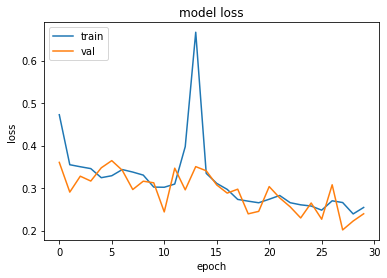

In [10]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [12]:
loss, mean_iou = unet_model.tf_model.evaluate(val_batches)
print(f"Loss: {loss}\nMean_IoU: {mean_iou}")

4/4 [==============================] - 3s 56ms/step - loss: 0.2850 - mean_io_u: 0.4520
Loss: 0.2849615216255188
Mean_IoU: 0.45201873779296875


1/1 [==============================] - 0s 67ms/step


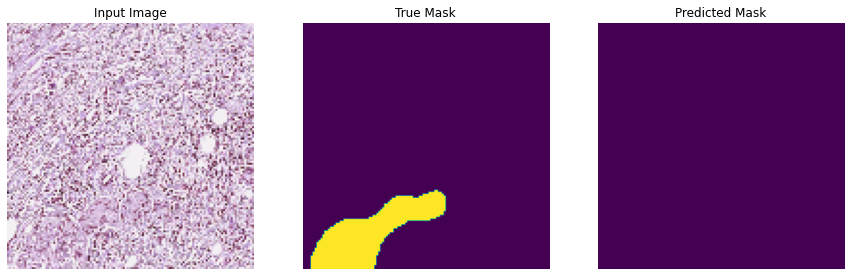

1/1 [==============================] - 0s 68ms/step


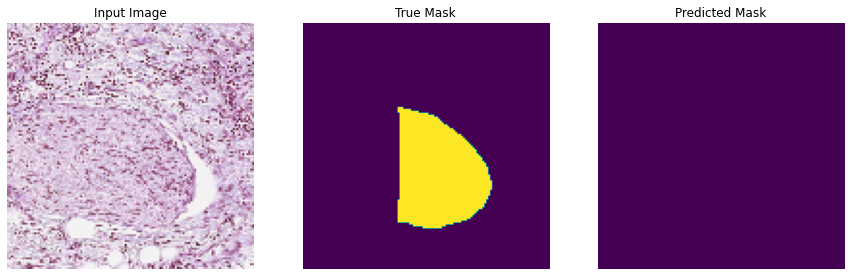

1/1 [==============================] - 0s 81ms/step


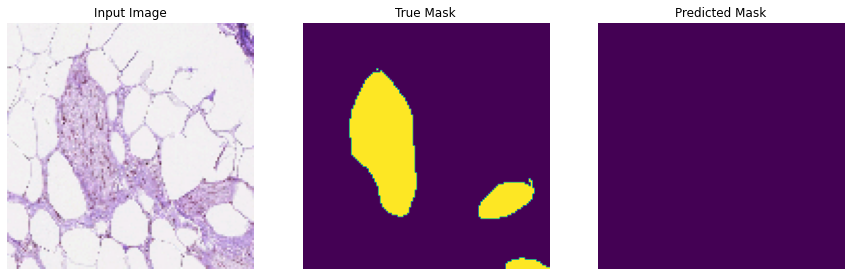

1/1 [==============================] - 0s 66ms/step


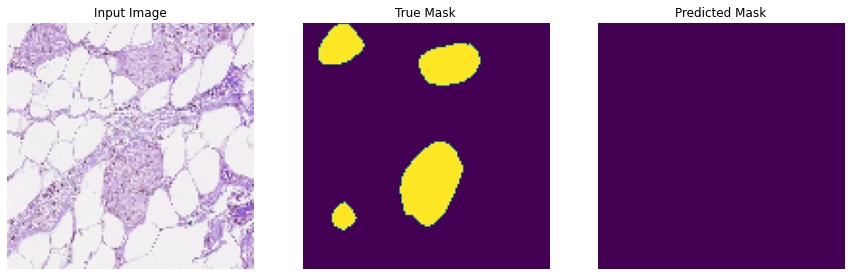

1/1 [==============================] - 0s 82ms/step


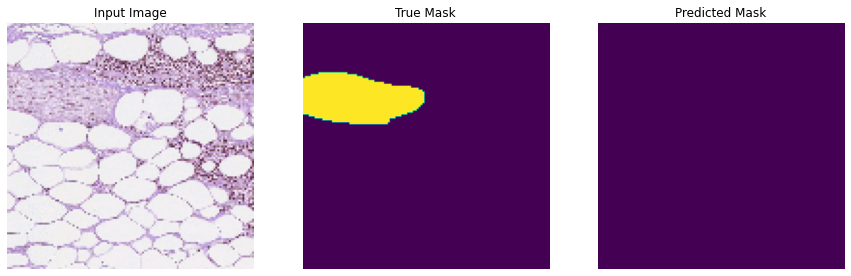

1/1 [==============================] - 0s 85ms/step


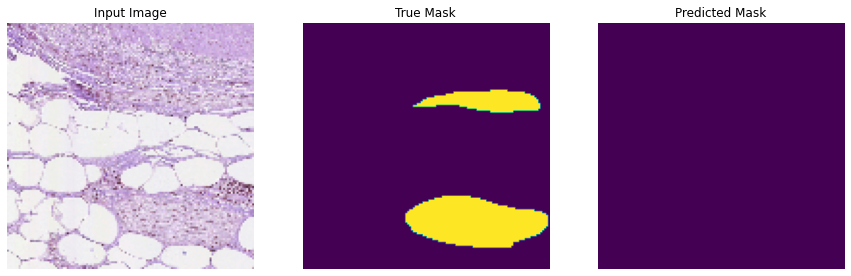

1/1 [==============================] - 0s 66ms/step


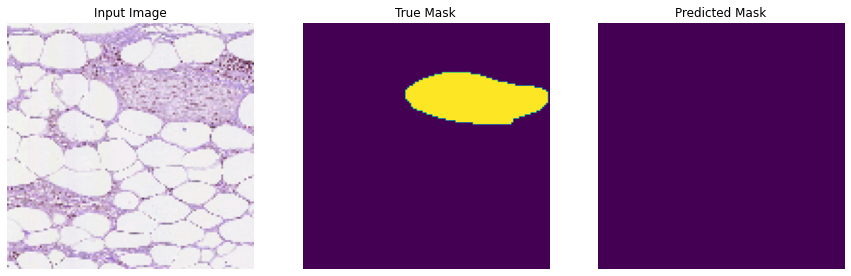

1/1 [==============================] - 0s 183ms/step


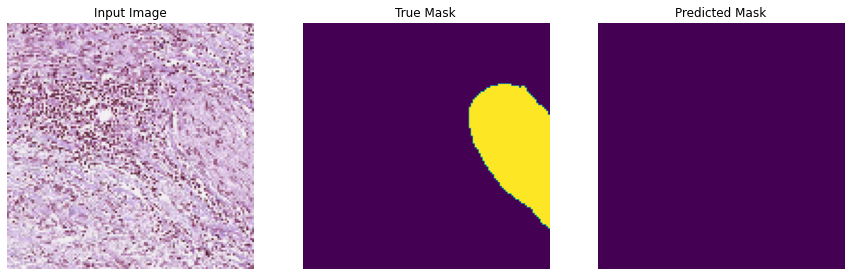

In [15]:
for batch in val_batches:
    for i in range(len(batch)):
        helpers.show(batch[0][i], batch[1][i], unet_model.predict(batch[0][i], True))
